In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# To get the PDF run:
# jupyter nbconvert Rapport.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to pdf

train = pd.read_pickle("dataset/train.bin.zst")
test = pd.read_pickle("dataset/test.bin.zst")
dev = pd.read_pickle("dataset/dev.bin.zst")

# Description de l'ensemble de données

## Informations générales


Le dataset est divisé en trois splits:
- `train.xml`: 665962 critiques
- `dev.xml`: 100400 critiques
- `test.xml`: 85847 critiques

Chaque critique est un avis portant sur un film, et est constituté de plusieurs champs:
- `movie`: L'ID du film sur AlloCiné. On peut accéder à la page d'un film à partir de ces ID via une URL spécifique sur le site d'AlloCiné.
- `name`: Le pseudonyme ou nom de l'utilisateur ayant posté la critique.
- `user_id`: L'ID de l'utilisateur sur AlloCiné.
- `note`: La note qui a été attribuée au film par l'utilisateur. Il s'agit d'une valeur numérique entre `0,5` et `5`. Ce champ est omis dans le split de test.
- `commentaire`: Le commentaire de l'utilisateur, qui est un champ textuel libre, et atteignant souvent les centaines de mots.

### Anomalies/particularités

On peut noter que pour certaines critiques ont un champ commentaire vide (12 dans le corpus train, 2 dans le corpus dev).

De plus, il y a plus d'ID numériques d'utilisateurs que de noms d'utilisateur, c'est-à-dire que plusieurs utilisateurs peuvent utiliser le même nom.

### Statistiques basiques sur les commentaires

In [3]:
max_comment_train = train["commentaire"].str.split("\\s+")
max_comment_dev = dev["commentaire"].str.split("\\s+")
max_comment_test = test["commentaire"].str.split("\\s+")


On trouve dans le split de train des commentaires vides ou allant jusqu'à 5302 mots pour un seul commentaire.

In [4]:
max_comment_train.str.len().max()


5302

In [5]:
max_comment_dev.str.len().max()


4187

In [6]:
max_comment_test.str.len().max()


3689

On peut aussi noter que pour 35344 ID utilisateurs différents, il n'y a que 32044 noms uniques.

In [7]:
len(dev["name"].unique())

32044

In [8]:
len(dev["user_id"].unique())

35344

# Approfondissement de l'analyse

## Répartition des notes dans nos données

Nous avons cherché à voir comment les notes étaient reparties dans notre jeu de données.  
Nous pouvons remarquées que les notes sont distribuées de manière très similaires entre le split de train et le split de dev.

De plus, les notes positives sont les plus courantes, et la tâche de classification 3-classes donne les notes positives comme très majoraitires.

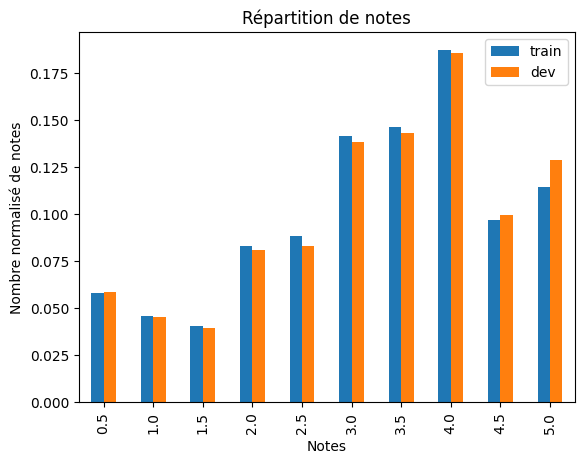

In [16]:
note_values = pd.DataFrame()
note_values["train"] = train["note"].value_counts(normalize=True).sort_index()
note_values["dev"] = dev["note"].value_counts(normalize=True).sort_index()
note_values.plot(kind="bar", title="Répartition de notes", xlabel="Notes", ylabel="Nombre normalisé de notes")
plt.show()

# three_classes = pd.DataFrame()
# three_classes["train"] = train["note"].transform(get_rating_class).value_counts(normalize=True).sort_index()
# three_classes["dev"] = dev["note"].transform(get_rating_class).value_counts(normalize=True).sort_index()
# three_classes.plot(kind="bar")  


## Distribution des notes de film

En observant 20 films au hasard (avec 100 critiques chacune minimum), on peut noter, sans surprise, que la notation des films est assez hétérogène.  

On peut cependant noter quelques faits intéressants:
- Certains films sont plus polarisants que d'autres, et amassent aussi bien beaucoup de critiques 5 étoiles que de critiques à 0,5 étoile.
- Certains films sont extrêmement bien notés, avec presque aucune critique négative.

<AxesSubplot:title={'center':'Distribution des notes pour 20 films choisis aléatoirement (100 critiques mini.)'}, ylabel='movie'>

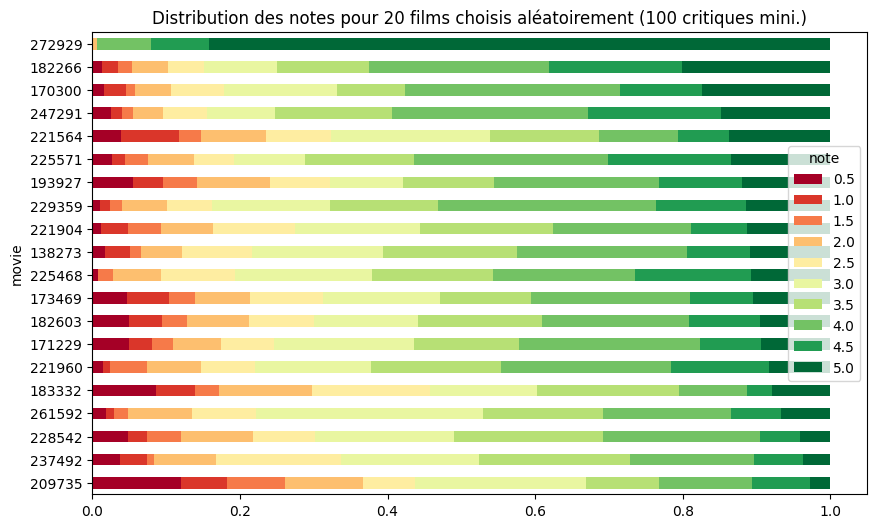

In [18]:
film_subset = dev

# remove movies with less than 100 reviews
film_subset = film_subset[film_subset.groupby("movie")["movie"].transform("count").ge(100)]

# make a table from the normalized frequency of each rating for each movie
film_subset = film_subset.groupby("movie").note.value_counts(normalize=True).unstack()

# sample 20 movies and create stacked horizontal bar plots of the ratings for each movie using a green-to-red colormap, sorted by the frequency of the 5-star rating
film_subset.sample(20).sort_values(5, ascending=True).plot.barh(title="Distribution des notes pour 20 films choisis aléatoirement (100 critiques mini.)", stacked=True, colormap="RdYlGn", figsize=(10, 6))

## Note moyenne du film par rapport au nombre de critiques

Globalement, plus un film a de critiques, plus la note moyenne tend vers le haut.

Text(0, 0.5, 'Nombre de critiques')

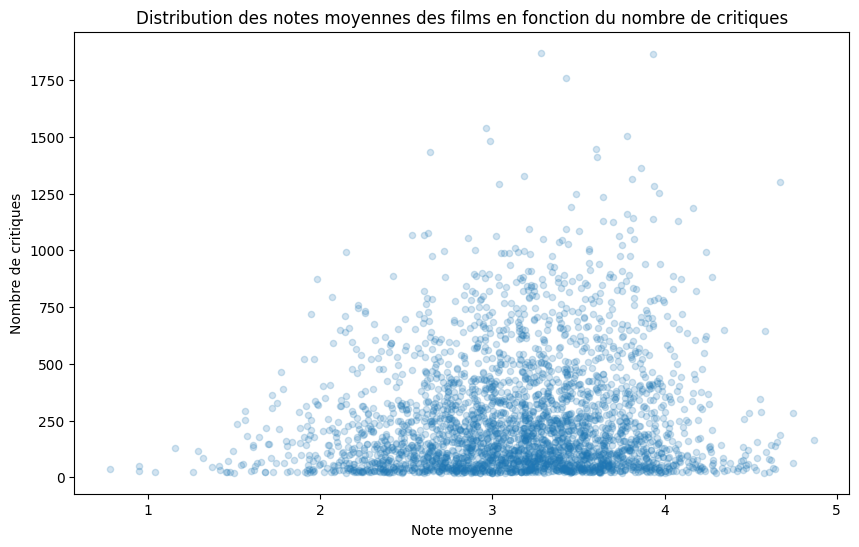

In [41]:
# plot movies average rating against number of reviews
film_subset = pd.concat([train, dev])

# remove movies with less than 20 reviews
film_subset = film_subset[film_subset.groupby("movie")["movie"].transform("count").ge(20)]

film_subset = film_subset.groupby("movie").agg({"note": "mean", "movie": "count"})

film_subset.plot.scatter(y="movie", x="note", title="Distribution des notes moyennes des films en fonction du nombre de critiques", figsize=(10, 6), alpha=0.2)
plt.xlabel("Note moyenne")
plt.ylabel("Nombre de critiques")

## Répartition des notes par rapport au nombre d'avis des utilisateurs

On peut voir avec cette répartition que plus le nombre de critiques publiées par un utilisateur est bas, plus les notes sont extrêmes que ce soit positivement ou négativement.  
Au cas contraire, plus une personne a publié de critiques, plus celles-ci sont en moyenne positives, et moins celles-ci tendent vers les extrêmes.

On fait ici l'analyse sur le corpus de train:

Text(0, 0.5, 'nombre de critiques (ÉCHELLE NON-LINÉAIRE!)')

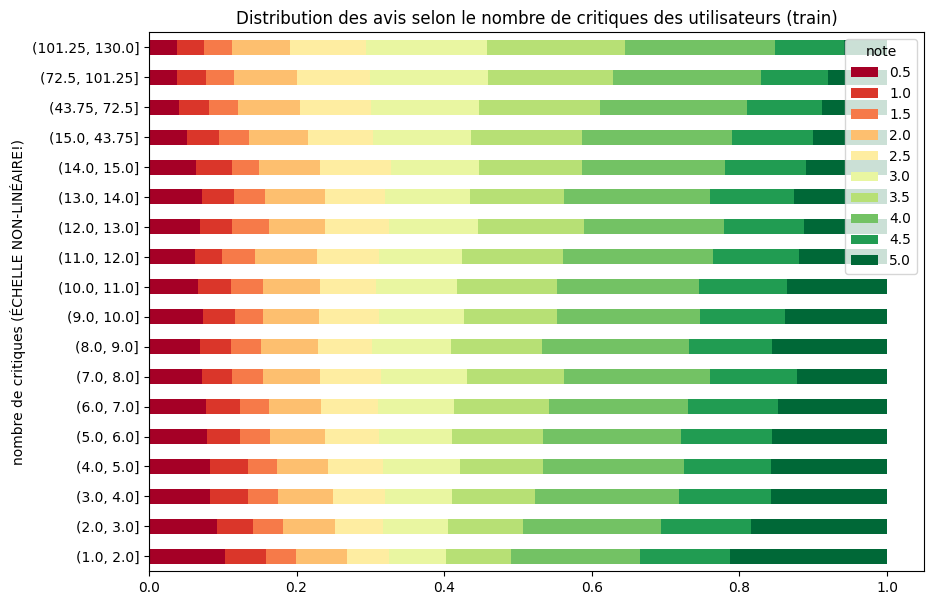

In [42]:
# bin users by the number of reviews they have written into 10 bins
user_subset = train
bins = np.concatenate((np.linspace(1, 14, 14), np.linspace(15, 130, 5)))

user_subset["bin"] = pd.cut(user_subset.groupby("user_id")["user_id"].transform("count"), bins)

# make a table from the normalized frequency of each rating for each user bin
user_subset = user_subset.groupby("bin").note.value_counts(normalize=True).unstack()

# create stacked horizontal bar plots of the ratings for each user bin using a green-to-red colormap
user_subset.plot.barh(title="Distribution des avis selon le nombre de critiques des utilisateurs (train)", stacked=True, colormap="RdYlGn", figsize=(10, 7))
plt.ylabel("nombre de critiques (ÉCHELLE NON-LINÉAIRE!)")

On peut comparer cette analyse au corpus de développement.

Il est possible de remarquer quelques différences, mais la plus faible taille de ce corpus ne nous permet probablement pas de tirer de conclusions significatives.  
On peut peut-être noter une proportion légèrement plus élevée d'avis moyens que d'avis positifs ou négatifs.

Text(0, 0.5, 'nombre de critiques (ÉCHELLE NON-LINÉAIRE!)')

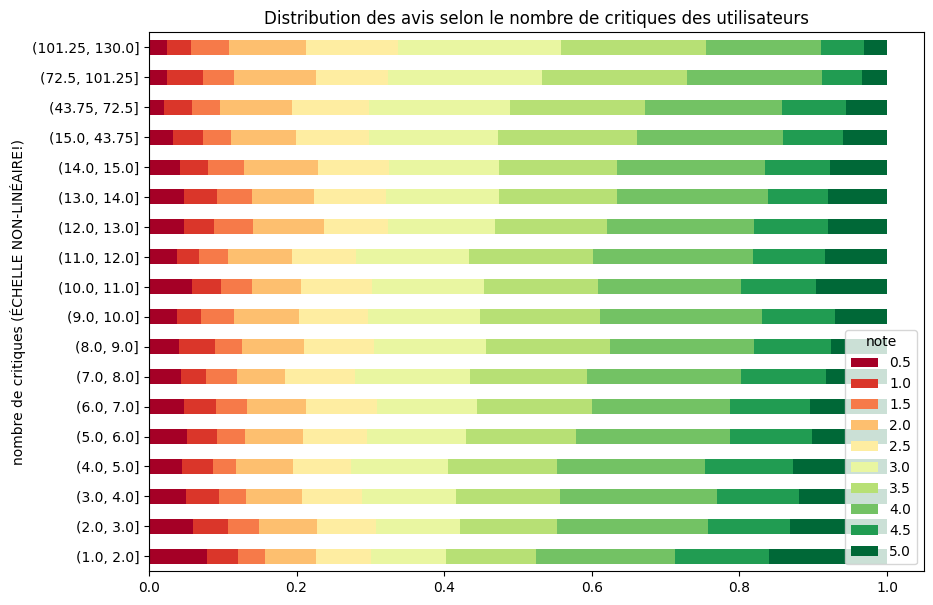

In [39]:
# bin users by the number of reviews they have written into 10 bins
user_subset = dev
bins = np.concatenate((np.linspace(1, 14, 14), np.linspace(15, 130, 5)))

user_subset["bin"] = pd.cut(user_subset.groupby("user_id")["user_id"].transform("count"), bins)

# make a table from the normalized frequency of each rating for each user bin
user_subset = user_subset.groupby("bin").note.value_counts(normalize=True).unstack()

# create stacked horizontal bar plots of the ratings for each user bin using a green-to-red colormap
user_subset.plot.barh(title="Distribution des avis selon le nombre de critiques des utilisateurs", stacked=True, colormap="RdYlGn", figsize=(10, 7))
plt.ylabel("nombre de critiques (ÉCHELLE NON-LINÉAIRE!)")

## Corrélation entre note et statistiques sur les commentaires

- Plus un commentaire a de phrases ou de mots, moins la note tend à être élevée.
- Une plus forte corrélation inverse entre le nombre de points et la note s'observe, ce qu'on attribue à la présence de trois petits points "..."
- Les points d'interrogation sont aussi corrélés négativement, certainement du au questionnement sur les films ou alors sur une incompréhension de celui-ci.
- Il n'y a que les majuscules et les points d'exclamation qui sont corrélés faiblement et fortement positivement respectivement.

<AxesSubplot:title={'center':'Corrélation avec la note'}>

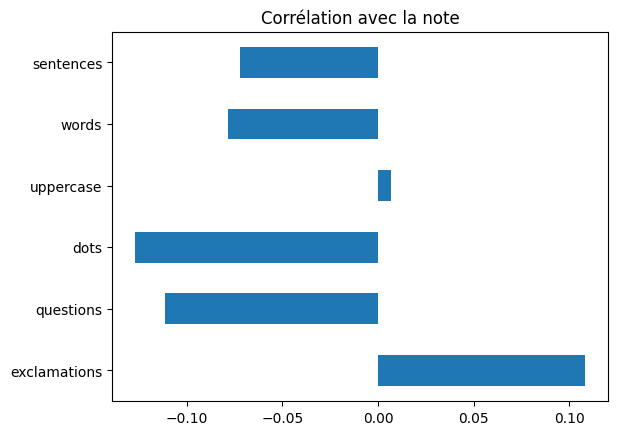

In [44]:
# count the amount of exclamation marks in each review
dev["exclamations"] = dev["commentaire"].transform(lambda text: text.count("!"))

# count the amount of question marks in each review
dev["questions"] = dev["commentaire"].transform(lambda text: text.count("?"))

# count the number of dots in each review
dev["dots"] = dev["commentaire"].transform(lambda text: text.count("."))

# count the amount of uppercase words in each review
dev["uppercase"] = dev["commentaire"].transform(lambda text: sum(1 for word in text.split() if word.isupper()))

# count the amount of words in each review
dev["words"] = dev["commentaire"].transform(lambda text: len(text.split()))

# count the number of sentences in each review
dev["sentences"] = dev["commentaire"].transform(lambda text: len(list(word for word in text.split(".") if len(word) != 0)))

# plot the correlation between every feature and the rating
dev[["exclamations", "questions", "dots", "uppercase", "words", "sentences", "note"]].corr("spearman").note.drop("note").plot.barh(title="Corrélation avec la note")